# Wine Study

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import graphviz

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
Image(url= "https://i.f1g.fr/media/figaro/616x347_crop/2015/04/28/XVM71060f5e-ed01-11e4-b7c4-1ce1633e8e3a.jpg")

# Data exploration

In [3]:
df = pd.read_csv("assignment_dataset.csv")
DATA = df.copy() #might need a fresh copy for question 2 and 3

In [4]:
df.head()

,title,variety,designation,country,province,description,price,winery,taster_name,points
0,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Vulkà Bianco,Italy,Sicily & Sardinia,"Aromas include tropical fruit, broom, brimston...",NaN,Nicosia,Kerin O’Keefe,87
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,"This is ripe and fruity, a wine that is smooth...",15.0,Quinta dos Avidagos,Roger Voss,87
2,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,NaN,US,Oregon,"Tart and snappy, the flavors of lime flesh and...",14.0,Rainstorm,Paul Gregutt,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,"Pineapple rind, lemon pith and orange blossom ...",13.0,St. Julian,Alexander Peartree,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,"Much like the regular bottling from 2012, this...",65.0,Sweet Cheeks,Paul Gregutt,87


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 10 columns):
title          129971 non-null object
variety        129970 non-null object
designation    92506 non-null object
country        129908 non-null object
province       129908 non-null object
description    129971 non-null object
price          120975 non-null float64
winery         129971 non-null object
taster_name    103727 non-null object
points         129971 non-null int64
dtypes: float64(1), int64(1), object(8)
memory usage: 9.9+ MB


As we can see, points seems to explain quite nicely the price, but there's a lot of outliers...

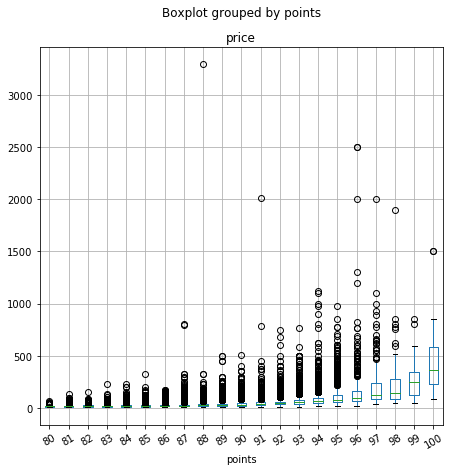

In [6]:
df.boxplot('price','points',rot = 30,figsize=(7,7));

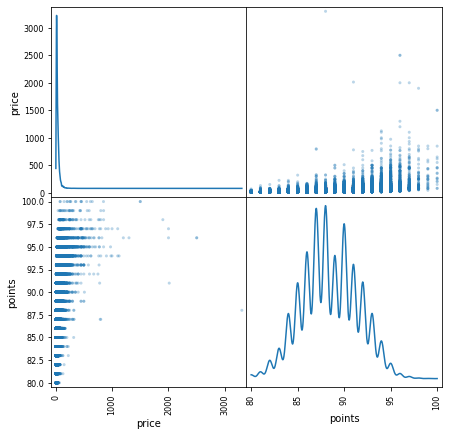

In [7]:
pd.plotting.scatter_matrix(df,diagonal='kde',figsize=(7, 7),alpha=0.3)
plt.show()

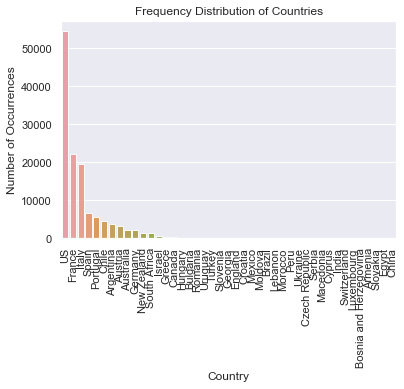

In [8]:
country_count = df['country'].value_counts()
sns.set(style="darkgrid")
countries = sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Frequency Distribution of Countries')
countries.set_xticklabels(countries.get_xticklabels(), rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

# Data cleaning

I dropped all rows containing NaNs, i could have used a KNN or RandomForest imputer but i made at the fastest.

In [9]:
df = df.dropna()

cast to categorical :

In [10]:
df_title = pd.Categorical(df.title)
df_title

[Quinta dos Avidagos 2011 Avidagos Red (Douro), St. Julian 2013 Reserve Late Harvest Riesling ..., Sweet Cheeks 2012 Vintner's Reserve Wild Child..., Tandem 2011 Ars In Vitro Tempranillo-Merlot (N..., Terre di Giurfo 2013 Belsito Frappato (Vittoria), ..., Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee), Domaine Rieflé-Landmann 2013 Seppi Landmann Va..., Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ..., Domaine Gresser 2013 Kritt Gewurztraminer (Als..., Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...]
Length: 69919
Categories (63452, object): [1+1=3 2008 Rosé Cabernet Sauvignon (Penedès), 1+1=3 NV Brut Sparkling (Cava), 1+1=3 NV Cygnus Brut Nature Reserva Made With ..., 1+1=3 NV Rosé Sparkling (Cava), ..., àMaurice NV Pour Me Red (Columbia Valley (WA)), Štoka 2009 Izbrani Teran (Kras), Štoka 2011 Grganja Vitovska (Kras), Štoka 2011 Izbrani Teran (Kras)]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69919 entries, 1 to 129970
Data columns (total 10 columns):
title          69919 non-null object
variety        69919 non-null object
designation    69919 non-null object
country        69919 non-null object
province       69919 non-null object
description    69919 non-null object
price          69919 non-null float64
winery         69919 non-null object
taster_name    69919 non-null object
points         69919 non-null int64
dtypes: float64(1), int64(1), object(8)
memory usage: 5.9+ MB


# Question 1 : Price prevision

I drop the description, i could have used a tf-idf to find most relevant words, and cast it to categorical, but also made at the fastest.

In [12]:
df = df.drop("description", axis=1)

In [13]:
df_num = df[["price", "points"]]

<div class="alert alert-info">
I decided to use only country, variety and designation, which seems to me the most relevant features, as there already are a lot of modalities.
Using One-hot encoding would have been better, but my RAM can't handle such amount of columns stored in a single dataframe.

In [14]:
df_cat = df[["country", "variety", "designation"]]
df_cat.head()

,country,variety,designation
1,Portugal,Portuguese Red,Avidagos
3,US,Riesling,Reserve Late Harvest
4,US,Pinot Noir,Vintner's Reserve Wild Child Block
5,Spain,Tempranillo-Merlot,Ars In Vitro
6,Italy,Frappato,Belsito


In [15]:
df_test = pd.concat([df_cat, df_num], axis = 1)
df_test.head()

,country,variety,designation,price,points
1,Portugal,Portuguese Red,Avidagos,15.0,87
3,US,Riesling,Reserve Late Harvest,13.0,87
4,US,Pinot Noir,Vintner's Reserve Wild Child Block,65.0,87
5,Spain,Tempranillo-Merlot,Ars In Vitro,15.0,87
6,Italy,Frappato,Belsito,16.0,87


Here's the final datset used for the algorithms

In [16]:
encoder = ce.BinaryEncoder(cols=['country', 'variety', 'designation'])
df_test = encoder.fit_transform(df_test)
df_test.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10,designation_0,designation_1,designation_2,designation_3,designation_4,designation_5,designation_6,designation_7,designation_8,designation_9,designation_10,designation_11,designation_12,designation_13,designation_14,designation_15,price,points
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15.0,87
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.0,87
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,65.0,87
5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15.0,87
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,16.0,87


# Decision Tree

I decided to use a decision tree, as it is fast to train on such a large dataset, tuning is quite easy, and above all, even if accuracy is not the better, the interpretation is very clear, and that's what we're gonna need if we want to be sure of our decision to attribute a certain price on a designated bottle.

In [17]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [18]:
X, y = df_test.drop("price", axis=1), df_test[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regressor = DecisionTreeRegressor(random_state=0)
path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

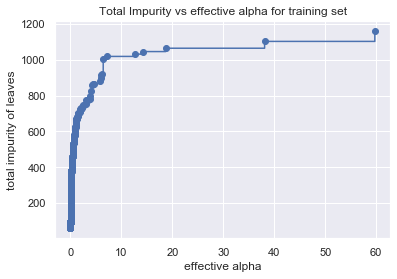

In [19]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

<div class="alert alert-warning">
Warning : this cell can be long to compute, about 60 seconds with my laptop.  
It's a grid search for pruning tuning
</div>

In [20]:
# ccp_alphas = np.linspace(0, 10, num=5).tolist()+np.linspace(20, 60, num=3).tolist()
# regrs = []
# for ccp_alpha in ccp_alphas:
#     regr = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
#     regr.fit(X_train, y_train)
#     regrs.append(regr)

In [21]:
# train_scores = [regr.score(X_train, y_train) for regr in regrs]
# test_scores = [regr.score(X_test, y_test) for regr in regrs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train",
#         drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

In [22]:
Image(url= "data/pruning_gs_results.png")

We can see that the best pruning is for ccp_alpha = 10, but we may want to take up until 60, as accuracy is not far below, and the tree is much easier to understand :

In [23]:
regressor = DecisionTreeRegressor(ccp_alpha=10).fit(X_train, y_train)

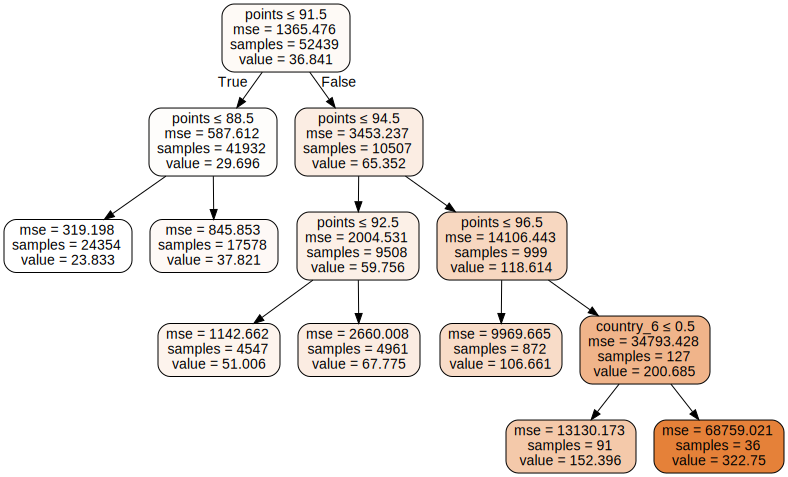

In [24]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                     feature_names=X_train.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [25]:
scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error')
scores

array([33.01024595, 28.78344442, 33.73374358, 30.00808813, 29.50550544])

In [26]:
np.mean(scores)

31.008205502951323

We can see that out of the 6 decision nodes, only one is made out of the country encoding, 
Of course, as we had to binary encode the categorical columns to make our decision tree work, the explaination of the graph is not that immediate. But we can still predict the price of the concerned wine, using the inverted dictionnary, and retriveing by then the name of the country, or variety.  
This is the best solution. 

However, **we may not have at our disposition the evaluation of the wine** we'd like to buy from the winemaker.  
In this case, if we only have the describing information about the proposed wine, we'd deal differently, using a KNN regressor. In that way, we can find the most ressembling wine and use its price to determine the price of the studied bottle.

# Without the notation info :

I remove the point feature :

In [27]:
df_test = df_test.drop("points", axis=1)
df_test.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10,designation_0,designation_1,designation_2,designation_3,designation_4,designation_5,designation_6,designation_7,designation_8,designation_9,designation_10,designation_11,designation_12,designation_13,designation_14,designation_15,price
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15.0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,65.0
5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15.0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,16.0


In [28]:
X, y = df_test.drop("price", axis=1), df_test[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [29]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [30]:
from sklearn.model_selection import cross_val_score

scores_knn = -cross_val_score(neigh, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error')
scores_knn

array([37.31185203, 33.74270474, 36.17032612, 32.90142179, 32.81186708])

In [31]:
np.mean(scores_knn)

34.58763435038638

We can see that the score without the notation is slightly higher, which is normal, as we have less data.  

<div class="alert alert-info">
This way we can use our data to have a fine prediction of the right selling price, wether we have the notation of the wine or not.  
We just have to reuse our trained model to have an accurate predictiopn of the selling price. Once we have this one, we can just adapt this forecasted-selling price to propose a buying price securing the best margin for our shop.

# Question 2 : Areas

We have to detect areas that are similar for production. I'm going for a clusterisation of the regions.  
My approach is the following :
- group regions (here this will be province) in cluster of same production type, using the grape variety
- select 5 best wines from each of these regions, in 3 categories of prices : under 10\$, under 50\$, and more than 50\$

The ebst would be to use NLP, to get the best defining words on both the title and the description. I'm however limited by time, i'll make at the simplest, and try to get groups using only the variety of the wine produced in each region.

I only need the province, points, variety, designation and title to do this :

In [32]:
df = DATA.copy()
df = df.drop(["description", "winery", "taster_name"], axis=1)
df = df.dropna()
df

,title,variety,designation,country,province,price,points
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,15.0,87
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,13.0,87
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,65.0,87
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Ars In Vitro,Spain,Northern Spain,15.0,87
6,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Belsito,Italy,Sicily & Sardinia,16.0,87
...,...,...,...,...,...,...,...
129963,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Oak Aged,Israel,Galilee,20.0,90
129965,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Seppi Landmann Vallée Noble,France,Alsace,28.0,90
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Brauneberger Juffer-Sonnenuhr Spätlese,Germany,Mosel,28.0,90
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Kritt,France,Alsace,30.0,90


In [33]:
len(df["variety"].unique())

630

In [34]:
len(df["province"].unique())

402

I'm obliged to use **binary encoding**, even if not best, if not i'm to work with more than 1000 columns, that my pc can't handle.

In [35]:
df_test = df[["province", "variety"]]
df_test

,province,variety
1,Douro,Portuguese Red
3,Michigan,Riesling
4,Oregon,Pinot Noir
5,Northern Spain,Tempranillo-Merlot
6,Sicily & Sardinia,Frappato
...,...,...
129963,Galilee,Cabernet Sauvignon
129965,Alsace,Pinot Gris
129966,Mosel,Riesling
129968,Alsace,Gewürztraminer


In [36]:
encoder = ce.BinaryEncoder(cols=['province', 'variety'])
df_encoded = encoder.fit_transform(df_test)
df_encoded.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1


I chose k means because it is fast and it can easily retrieves groups of points.

In [42]:
from sklearn.cluster import KMeans
inertias = [] 
mapping = {} 
K = 10

for k in range(1,K):
    kmeanModel = KMeans(n_clusters=k).fit(df_encoded) 
    inertias.append(kmeanModel.inertia_)  
    mapping[k] = kmeanModel.inertia_

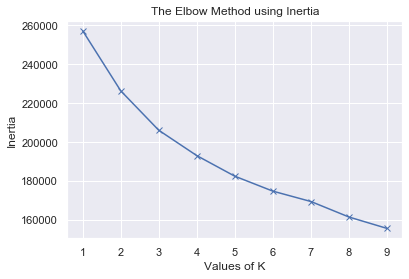

In [44]:
plt.plot(range(1,K), inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Using the albow method, we can see that the **best number of cluster seems to be 4. **  
However, it's maybe a bit short, we may want to use more group of regions, but we'll see about that.

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_encoded)

Here's the final dataset, with the cluster for each tested wine.

In [46]:
df["cluster"] = kmeans.labels_
df

,title,variety,designation,country,province,price,points,cluster
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Avidagos,Portugal,Douro,15.0,87,2
3,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,Reserve Late Harvest,US,Michigan,13.0,87,1
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Vintner's Reserve Wild Child Block,US,Oregon,65.0,87,2
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Ars In Vitro,Spain,Northern Spain,15.0,87,3
6,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Belsito,Italy,Sicily & Sardinia,16.0,87,3
...,...,...,...,...,...,...,...,...
129963,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Oak Aged,Israel,Galilee,20.0,90,2
129965,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Seppi Landmann Vallée Noble,France,Alsace,28.0,90,3
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Brauneberger Juffer-Sonnenuhr Spätlese,Germany,Mosel,28.0,90,1
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Kritt,France,Alsace,30.0,90,3


### Analysis of clustering :

In [47]:
df.cluster.value_counts()

2    25185
3    22642
1    22595
0    15726
Name: cluster, dtype: int64

<div class="alert alert-info">
Our clustering seems equilibrated, which is a very good sign

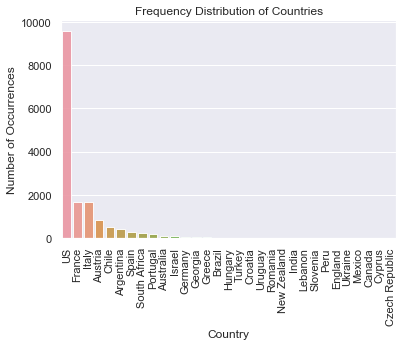

In [48]:
cluster = 0

country_count = df[df["cluster"]==cluster]['country'].value_counts()
sns.set(style="darkgrid")
countries = sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Frequency Distribution of Countries')
countries.set_xticklabels(countries.get_xticklabels(), rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

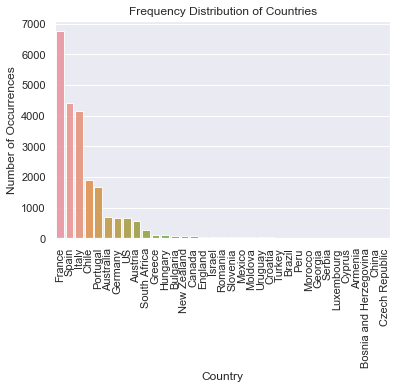

In [49]:
cluster = 3

country_count = df[df["cluster"]==cluster]['country'].value_counts()
sns.set(style="darkgrid")
countries = sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Frequency Distribution of Countries')
countries.set_xticklabels(countries.get_xticklabels(), rotation=90)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

It is always hard to guess if a clustering is done right or no, as its unsupervised, but we can see thet the groups are heterogenous enough to show that it has worked rather good.  
We have to keep in mind that from the beginning, the US-tested wine were largely overrepresented, so it's no surprise they still appear as the most representative country of 3 out of 4 clusters.

# Creating the list

And now, for each group, we get the best wines in each category of price:

### Under 10$ the bottle

In [50]:
group = 1
df[df["cluster"]==group].sort_values(by="points", ascending=False)[["title", "points", "country"]]#.tolist()

,title,points,country
7335,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,100,Italy
111754,Casanova di Neri 2007 Cerretalto (Brunello di...,100,Italy
35517,Tenuta San Guido 2012 Sassicaia (Bolgheri Sas...,99,Italy
82750,Avignonesi 1997 Occhio di Pernice (Vin Santo ...,99,Italy
47429,Williams Selyem 2010 Hirsch Vineyard Pinot Noi...,99,US
...,...,...,...
19563,California's Jewel 2004 Old Vine Zinfandel (Lodi),80,US
14337,Sunstone 2007 Syrah Rosé (Santa Ynez Valley),80,US
109225,Bryter 2009 Hayley Vineyard Pinot Noir (Anders...,80,US
109400,Pietra Santa 2009 Estate Grown Pinot Noir (Cie...,80,US


In [51]:
df_u10 = df[df["price"]<=10]
df_u50 = df[df["price"]<=50]
df_o50 = df[df["price"]>=50]

list_u10 = {}
list_u50 = {}
list_o50 = {}
for cluster in range(4):
    list_u10["cluster "+str(cluster)] = df_u10[df_u10["cluster"]==cluster].sort_values(by="points", ascending = False)["title"][:5].tolist()
    list_u50["cluster "+str(cluster)] = df_u50[df_u50["cluster"]==cluster].sort_values(by="points", ascending = False)["title"][:5].tolist()
    list_o50["cluster "+str(cluster)] = df_o50[df_o50["cluster"]==cluster].sort_values(by="points", ascending = False)["title"][:5].tolist()
list_u50

{'cluster 0': ['Trefethen 2005 Estate Cabernet Sauvignon (Oak Knoll District)',
  'Donkey & Goat 2010 Fenaughty Vineyard Syrah (El Dorado)',
  'Emmerich Knoll 2013 Loibner Auslese Grüner Veltliner (Wachau)',
  'Macauley 2007 Special Selected Late Harvest Botrytis Sémillon (Alexander Valley)',
  'Riglos 2009 Gran Corte Las Divas Vineyard Red (Tupungato)'],
 'cluster 1': ['Failla 2010 Estate Vineyard Chardonnay (Sonoma Coast)',
  'Williams Selyem 2010 Allen Vineyard Chardonnay (Russian River Valley)',
  'Limerick Lane 2013 Rocky Knoll Zinfandel (Russian River Valley)',
  'Dutton-Goldfield 2010 Dutton Ranch Rued Vineyard Chardonnay (Green Valley)',
  'Ryan Cochrane 2015 Solomon Hills Vineyard Chardonnay (Santa Maria Valley)'],
 'cluster 2': ['Pirouette 2008 Red Wine Red (Columbia Valley (WA))',
  'Tamarack Cellars 2008 DuBrul Vineyard Reserve Red Red (Rattlesnake Hills)',
  'Gramercy 2009 Lagniappe Syrah (Columbia Valley (WA))',
  'Colombera & Garella 2013 Pizzaguerra  (Lessona)',
  'Schl

<div class="alert alert-success">
We end up with a list of 60 selected bottles, within every range of price, and right for every type of taste, as they are selected from 4 types of production, worldwide.

# Question 3 : Blind Test

In [52]:
df = DATA.copy()

<div class="alert alert-info">
One of the most interesting project you want to
carry out is a blind tasting night every Wednesday. Describe which approach
you would follow to identify the characteristics of a wine, e.g., variety or
denomination, given their description.  

*Please, in your description specify how you would structure the project.*

I have to say i'm not 100% sure to understand the question.  
My understanding is that I need to analyse what people have inscribed on their review/description, during the blind testing and use it to guess what kind of wine it is.

We have below an example of a review :

In [53]:
df.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

I could use a **TF-IDF** algorithm to select the most important words out of the review, using the rest of the data i already have as the rest of the corpus.  
Here that would certainly be the words tropical fruit, broom, brimstone, herb, palate, expressive etc  

Then I could use the **A priori** algorithm which detects association of elements to guess the other features of the tested wine, like its origin, or even the name of the domain, if certain very specific words are related only to this one.

If this one doesn't perform correctly, i could try to guess a larger description using an **LDA** algorithm, which can guess the main themes of the description, and create a sort of clustering for the corpus. Then taking the principal mode of the regions, or the variety, i could make a guess for my tested wine.